Importamos las librerías que necesitaremos y fijamos la semilla para que los experimentos sean reproducibles

In [ ]:
import tensorflow as tf
import numpy as np
import time
import matplotlib.pyplot as plt
import pandas as pd

np.random.seed(33)

Hacemos una función para cargar los datos, normalizarlos, aplanarlos y agregar una entrada afín

In [ ]:
def cargar_datos():

    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

    x_train = x_train.astype("float32") / 255.0
    x_test = x_test.astype("float32") / 255.0

    x_train = x_train.reshape(-1, 28 * 28)
    x_test = x_test.reshape(-1, 28 * 28)

    x_train = np.append(x_train, np.ones((x_train.shape[0], 1)), axis=1)
    x_test = np.append(x_test, np.ones((x_test.shape[0], 1)), axis=1)

    return x_train, y_train, x_test, y_test

También implementamos una función que nos permita obtener una muestra aleatoria de los datos

In [ ]:
def random_subset(tamano, X, Y):
    n, d = X.shape
    indices = np.random.choice(n, size=tamano, replace=False)
    newX = X[indices]
    newY = Y[indices]
    return newX, newY

Implementamos la función objetivo

In [ ]:
def R(W, X, Y):
    n, d = X.shape
    P = X @ W.T
    term1 = -np.sum(P[np.arange(n), Y])
    term2 = np.sum(np.log(np.sum(np.exp(P), axis=1)))
    return (term1 + term2) / n

Y también implementamos el gradiente de la función objetivo

In [ ]:
def gradR(W, X, Y):
    n, d = X.shape
    K, d = W.shape

    P = X @ W.T
    p = np.exp(P) / np.sum(np.exp(P), axis=1, keepdims=True)
    grad = np.zeros_like(W)

    for k in range(K):
        indicator = (Y == k).astype(float)
        grad[k, :] = -np.sum((indicator[:, np.newaxis] - p[:, k][:, np.newaxis]) * X, axis=0) / n

    return grad

Implementamos una función que nos entregue la proporción de los datos clasificada correctamente

In [ ]:
def validar(W, X, Y):

    P = X @ W.T
    p = np.exp(P)/np.sum(np.exp(P), axis=1, keepdims=True)
    Ypred = np.argmax(p, axis=1)
    error = np.mean(Ypred != Y)
    return error

Y además una función que nos permita hacer un análisis sobre los datos en los que la clasificación es incorrecta

In [ ]:
def analisiserror(W, X, Y):
    P = X @ W.T
    p = np.exp(P)/np.sum(np.exp(P), axis=1, keepdims=True)
    Ypred = np.argmax(p, axis=1)
    errores = np.where(Ypred != Y)[0]

    indices = np.random.choice(errores, size=3, replace=True)

    for indice in indices:
        imagen = X[indice][:-1].reshape(28, 28)
        label = Y[indice]
        labelpred = Ypred[indice]
        plt.imshow(imagen, cmap='gray')
        plt.title(f"Es un {label} y lo clasificamos como {labelpred} con {(100*p[indice][labelpred]):.2f}% de confianza")
        plt.axis('off')
        plt.show()

Implementamos el primer algoritmo de la tarea de la misma forma en la que está enunciado, aprovechandonos de las funciones implementadas anteriormente

In [ ]:
def descenso_gradiente_backtracking(X, Y, K, T):
    n, d = X.shape
    W = np.zeros((K, d))
    eta = 1
    time_start = time.time()

    iters = 0

    while time.time() - time_start < T:
        fprima = gradR(W, X, Y)
        while R(W - eta*fprima, X, Y) > R(W, X, Y) - (eta / 2) * np.linalg.norm(fprima) ** 2:
            eta /= 2
        W -= eta * fprima
        iters += 1

    print(f"Alcanzamos a hacer {iters} iteraciones")

    return W

Cargamos los datos para después comenzar con los experimentos

In [ ]:
x_train, y_train, x_test, y_test = cargar_datos()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Comenzamos con un subconjunto de $100$ datos

Alcanzamos a hacer 65756 iteraciones
Fallamos en la clasificación de un 0.00% de los datos de entrenamiento
Fallamos en la clasificación de un 26.18% de los datos de testing


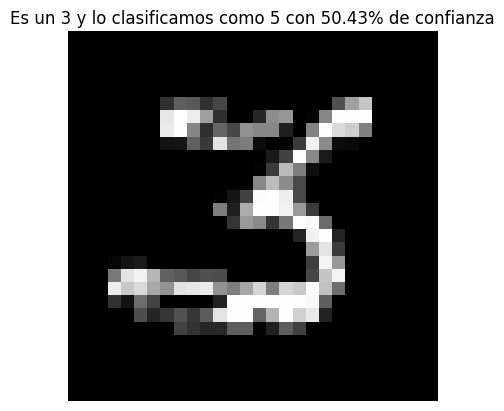

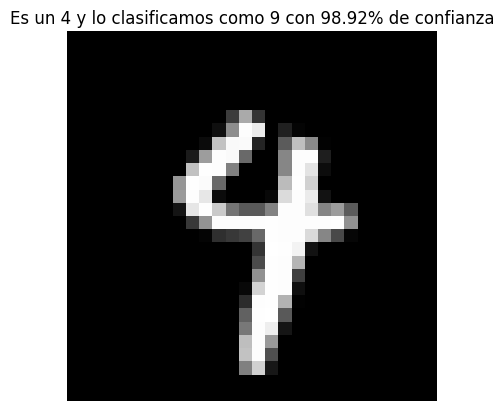

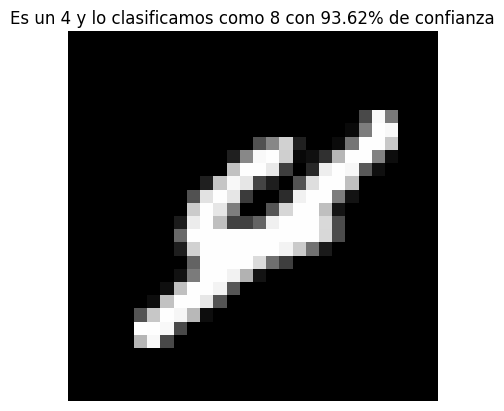

In [ ]:
x, y = random_subset(100, x_train, y_train)
W = descenso_gradiente_backtracking(x, y, 10, 300)
print(f"Fallamos en la clasificación de un {(100*validar(W, x, y)):.2f}% de los datos de entrenamiento")
print(f"Fallamos en la clasificación de un {(100*validar(W, x_test, y_test)):.2f}% de los datos de testing")
analisiserror(W, x_test, y_test)

Se alcanzaron a realizar mas de 60 mil iteraciones. Se observa que el error en los datos que vio es de 0% pero en los datos de testeo es alto, con más de una de cada cuatro vez equivocandose. Esto se debe a que vio pocos datos y los vio muchas veces así que se sobreajustó. Aún así los datos en los que falló no son demasiado claros, pero estaba bien seguro aún estando equivocado

Ahora veamos con un conjunto de datos de entrenamiento de 1000 datos

Alcanzamos a hacer 8207 iteraciones
Fallamos en la clasificación de un 0.00% de los datos de entrenamiento
Fallamos en la clasificación de un 13.18% de los datos de testing


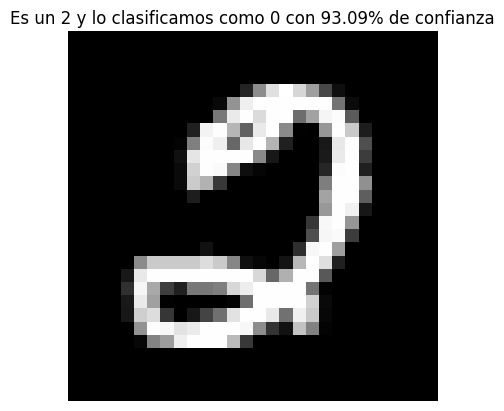

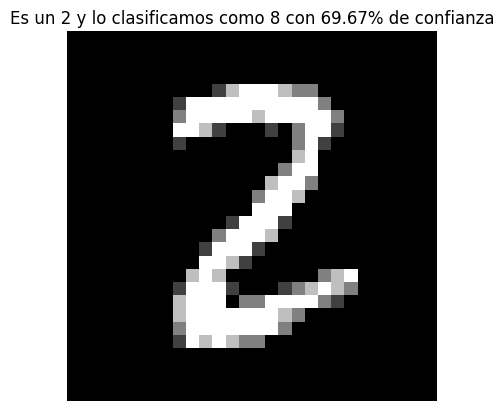

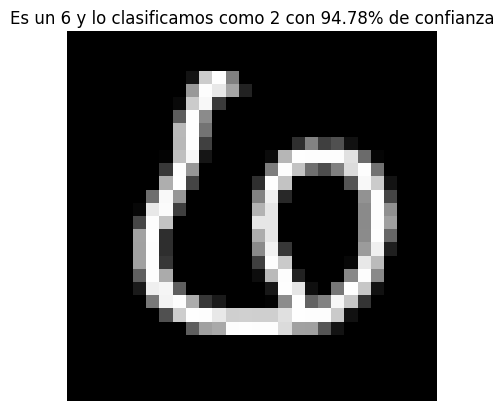

In [ ]:
x, y = random_subset(1000, x_train, y_train)
W = descenso_gradiente_backtracking(x, y, 10, 300)
print(f"Fallamos en la clasificación de un {(100*validar(W, x, y)):.2f}% de los datos de entrenamiento")
print(f"Fallamos en la clasificación de un {(100*validar(W, x_test, y_test)):.2f}% de los datos de testing")
analisiserror(W, x_test, y_test)

Se alcanzaron a realizar mas de 8 mil iteraciones. Se observa que el error en los datos que vio es de 0% y en los datos de testeo bajó a la mitad comparado a lo anterior. Este porcentaje ya es más razonable y los datos en los que falló estaban un poco extraños a decir verdad, al parecer tiene problemas para identificar el 2

Ahora veamos que ocurre con un conjunto de datos de entrenamiento de 10 mil datos

Alcanzamos a hacer 676 iteraciones
Fallamos en la clasificación de un 6.93% de los datos de entrenamiento
Fallamos en la clasificación de un 8.77% de los datos de testing


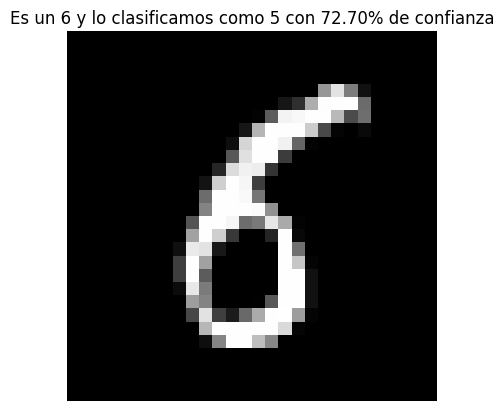

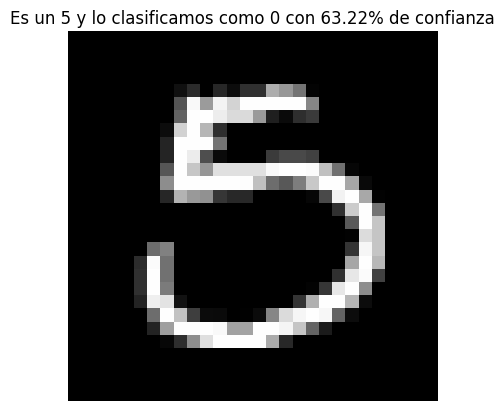

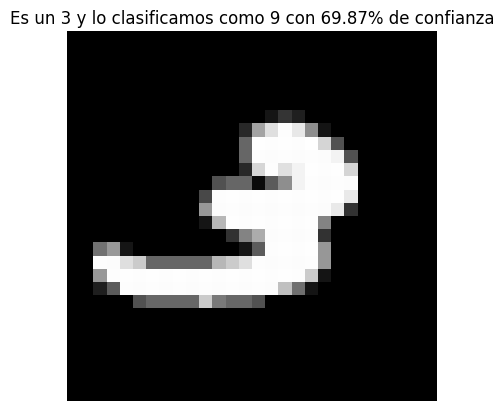

In [ ]:
x, y = random_subset(10000, x_train, y_train)
W = descenso_gradiente_backtracking(x, y, 10, 300)
print(f"Fallamos en la clasificación de un {(100*validar(W, x, y)):.2f}% de los datos de entrenamiento")
print(f"Fallamos en la clasificación de un {(100*validar(W, x_test, y_test)):.2f}% de los datos de testing")
analisiserror(W, x_test, y_test)

Se alcanzaron a realizar mas de 600 iteraciones. Se observa que el error en los datos que vio no es de 0% y en los de testo bajó a casi la mitad comparado a lo anterior. Este es un claro indicio que ya tiene una muestra lo suficientemente grande como para dejar de sobreajustarse, además de que no alcanzó a hacer tantas iteraciones. Aún así considero que en los datos en los que falló igual son claros de identificar, pero estaba menos seguro que en los casos anteriores.

Ahora veamos que ocurre con el conjunto de datos completo

Alcanzamos a hacer 107 iteraciones
Fallamos en la clasificación de un 10.42% de los datos de entrenamiento
Fallamos en la clasificación de un 9.77% de los datos de testing


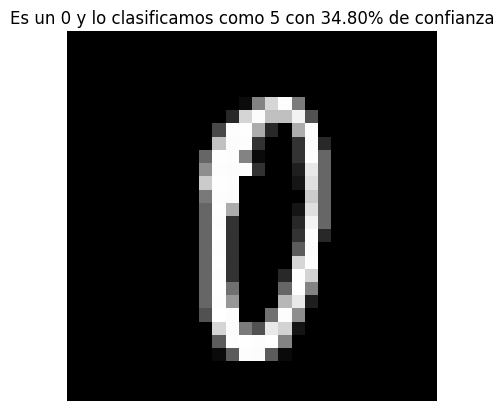

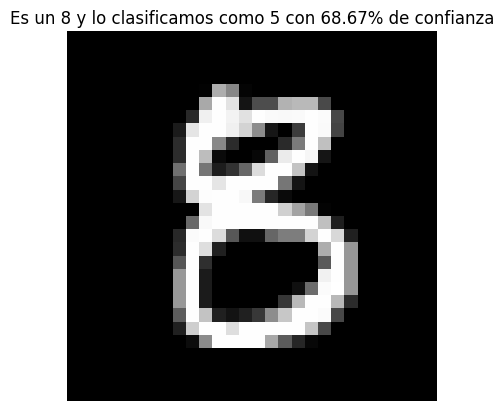

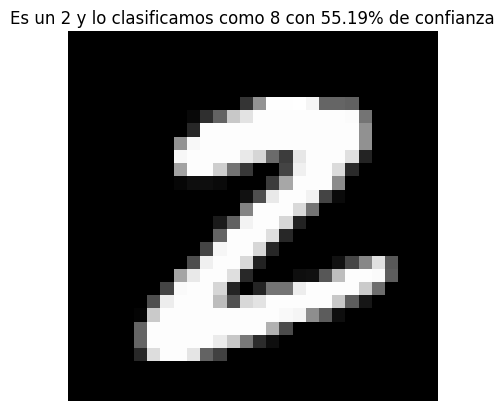

In [ ]:
W = descenso_gradiente_backtracking(x_train, y_train, 10, 300)
print(f"Fallamos en la clasificación de un {(100*validar(W, x_train, y_train)):.2f}% de los datos de entrenamiento")
print(f"Fallamos en la clasificación de un {(100*validar(W, x_test, y_test)):.2f}% de los datos de testing")
analisiserror(W, x_test, y_test)

Se alcanzaron a realizar mas de 100 iteraciones. Se observa que tanto el error en los datos que vio como en los que no vio aumentó. Este es un claro indicio de que el modelo no alcanzó a converger y por tanto con muchos datos no alcanzó a hacer iteraciones suficientes para conseguir un buen resultado. De hecho, los datos en los que falló no son demasiado extraños, aunque no está demasiado seguro tampoco

Ahora implementamos el algoritmo de descenso de gradiente estocástico secuencial

In [ ]:
def descenso_gradiente_estocastico(X, Y, K, T, eta):
    n, d = X.shape
    W = np.zeros((K, d))
    Ave = np.zeros((K, d))
    time_start = time.time()

    for t in range(n+1):
        if (time.time() - time_start >= T) or (t == n):
            print(f"Alcanzamos a explorar {t} datos")
            break
        fprima = gradR(W, X[t:t+1], Y[t:t+1])
        Wprima = W - eta*fprima
        Ave = (t/(t+1))*Ave + (1/(t+1))*Wprima
        W = Wprima

    return Ave

Entrenamos los modelos para los distintos $l$

In [ ]:
for l in range(1, 5):
    print(f"Entrenando el modelo para l = {l}")
    eta = 10**(-l)
    W = descenso_gradiente_estocastico(x_train, y_train, 10, 300, eta)
    print(f"Fallamos en la clasificación de un {(100*validar(W, x_train, y_train)):.2f}% de los datos de entrenamiento")
    print(f"Fallamos en la clasificación de un {(100*validar(W, x_test, y_test)):.2f}% de los datos de testing")
    print()

Entrenando el modelo para l = 1
Alcanzamos a explorar 60000 datos
Fallamos en la clasificación de un 7.81% de los datos de entrenamiento
Fallamos en la clasificación de un 7.78% de los datos de testing

Entrenando el modelo para l = 2
Alcanzamos a explorar 60000 datos
Fallamos en la clasificación de un 8.54% de los datos de entrenamiento
Fallamos en la clasificación de un 8.21% de los datos de testing

Entrenando el modelo para l = 3
Alcanzamos a explorar 60000 datos
Fallamos en la clasificación de un 11.44% de los datos de entrenamiento
Fallamos en la clasificación de un 10.77% de los datos de testing

Entrenando el modelo para l = 4
Alcanzamos a explorar 60000 datos
Fallamos en la clasificación de un 17.11% de los datos de entrenamiento
Fallamos en la clasificación de un 16.27% de los datos de testing



Notamos que el algoritmo alcanzó a explorar todos los datos y de hecho fue muy rápido. El modelo que mejor anduvo fue el con el $\eta$ más pequeño y tuvo un buen rendimiento aún cuando cada dato lo vio solamente una vez. Veamos en que datos fueron los que falló

Alcanzamos a explorar 60000 datos


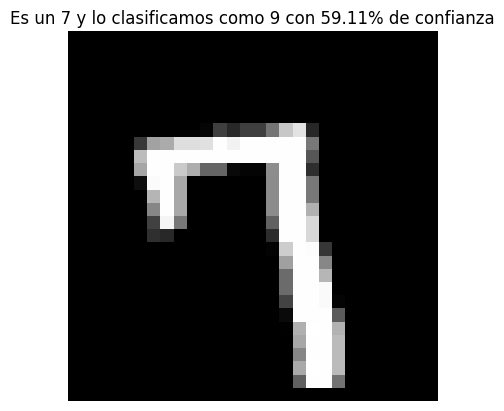

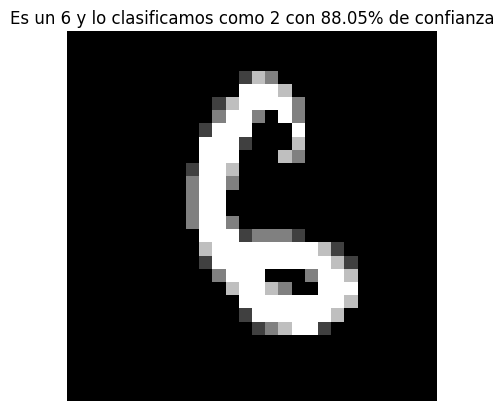

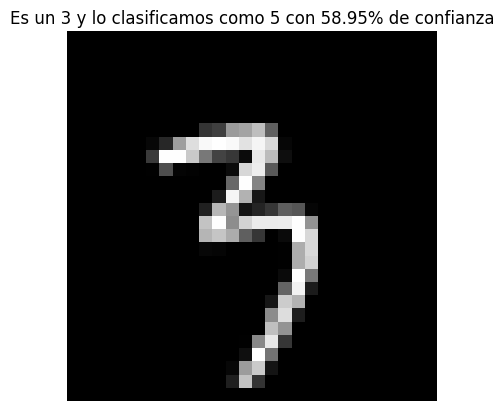

In [ ]:
W = descenso_gradiente_estocastico(x_train, y_train, 10, 300, 0.1)
analisiserror(W, x_train, y_train)

Esta vez los ejemplos en los que falla están bastante bizarros, y el modelo realmente no está muy seguro en ellos. Tiene sentido sus fallos

Ahora implementemos la versión con una muestra aleatoria

In [ ]:
def descenso_gradiente_estocastico_aleatorio(X, Y, K, T, eta, M):
    n, d = X.shape
    W = np.zeros((K, d))
    Ave = np.zeros((K, d))
    time_start = time.time()

    iters = 0

    while time.time() - time_start < T:
        Xbatch, Ybatch = random_subset(M, X, Y)
        fprima = gradR(W, Xbatch, Ybatch)
        Wprima = W - eta*fprima
        Ave = (iters/(iters+1))*Ave + (1/(iters+1))*Wprima
        W = Wprima
        iters+=1

    return Ave

Corremos el algoritmo para los distintos parámetros y guardamos su resultado

In [ ]:
datatrain = np.zeros((4, 4))
datatest = np.zeros((4, 4))
for l in range(1, 5):
    for p in range(1, 5):
        eta = 10**(-l)
        M = 10**p
        W = descenso_gradiente_estocastico_aleatorio(x_train, y_train, 10, 300, eta, M)
        datatrain[l-1][p-1] = validar(W, x_train, y_train)
        datatest[l-1][p-1] = validar(W, x_test, y_test)

Graficamos los resultados

In [ ]:
dftrain = pd.DataFrame(datatrain, columns=['p=1', 'p=2', 'p=3', 'p=4'], index=['l=1', 'l=2', 'l=3', 'l=4'])
dftest = pd.DataFrame(datatest, columns=['p=1', 'p=2', 'p=3', 'p=4'], index=['l=1', 'l=2', 'l=3', 'l=4'])

print(dftrain.round(3))
print()
print(dftest.round(3))

       p=1    p=2    p=3    p=4
l=1  0.065  0.069  0.081  0.112
l=2  0.076  0.084  0.107  0.166
l=3  0.098  0.116  0.156  0.252
l=4  0.142  0.174  0.243  0.312

       p=1    p=2    p=3    p=4
l=1  0.074  0.075  0.079  0.105
l=2  0.077  0.082  0.100  0.157
l=3  0.092  0.109  0.147  0.245
l=4  0.132  0.164  0.236  0.308


Se puede percibir la diferencia en los resultados entre los distintos modelos, por lo cual es claro que el algoritmo es sensible a los parámetros. Por otra parte, no hay una gran diferencia entre el error de test y el error de validación, lo cual es un claro indicio de que el algoritmo no se está sobreajustando.

Comparado al modelo de la parte c, tuvieron rendimientos realmente muy similares, lo cual tiene sentido ya que son algoritmos parecido